In [13]:
from IPython.display import Image

# Satellite Image Analysis GGS416 

In this tutorial we are going to focus on how to use a loop to clip a satellite image, and then export the resulting data. 

The content builds off the code in the previous tutorial. 

Let's begin by using the same code we used in the previous tutorial. First, let's load and show our image:


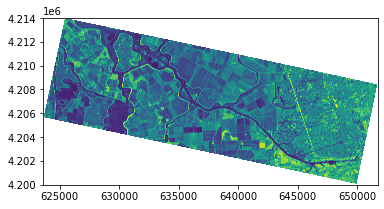

<AxesSubplot:>

In [14]:
import rasterio
from matplotlib import pyplot as plt
from rasterio.mask import mask
    
# This notebook explores a single 4 band (blue, green, red, NIR) PlanetScope scene in a UTM projection.
image_file = "../week3/20160831_180302_0e26_3B_Visual.tif"

# Use Rasterio to open the image.
my_image = rasterio.open(image_file)
my_image

# We can take a quick look using the rasterio.plot.show function 
# This is a matplotlib shortcut for visualizing the raster 
from rasterio.plot import show
show(my_image)

We then need our image bounds as the xmin, ymin, xmax, ymax.

Additionally, let's take the range for each axis too. 

In [15]:
# So we can get our image bounds
xmin, ymin, xmax, ymax = my_image.bounds

# Let's get the x and y range first 
x_range = xmax - xmin
y_range = ymax - ymin
print(x_range, y_range)

28155.0 14052.0


As an example, let's split these images up into four individual images. 

To do that, we will need the four bounding box coordinates. 

The image below provides an illustration for how we will define the coordinates using the minimum, maximum and range values for each axis. 

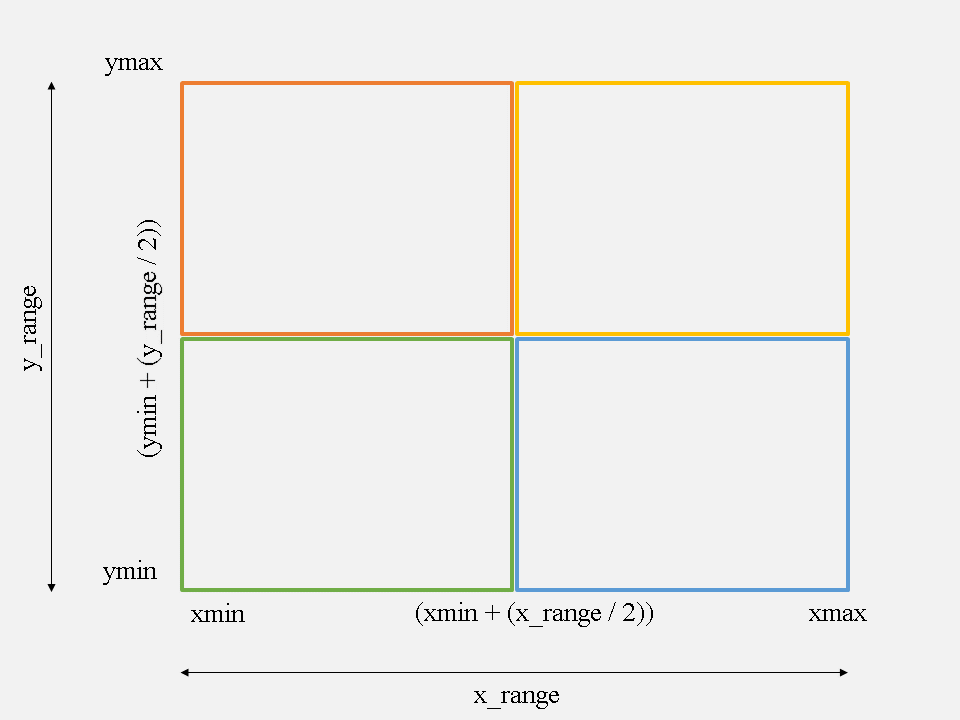

In [16]:
Image("../week5/images/bbox.png")

To make sure we can loop over these coordinates, let's create a list of tuples to hold this information.

Each tuple will be based on the following structure:
    
```(x1, y1, x2, y2)```


In [17]:
coords = [
    (xmin,   ymin, (xmin + (x_range/2)), (ymin + (y_range/2))), #bounding box 1
    (xmin,   (ymin + (y_range/2)), (xmin + (x_range/2)), ymax), #bounding box 2
    ((xmin + (x_range/2)),   ymin, xmax, (ymin + (y_range/2))), #bounding box 3
    ((xmin + (x_range/2)),   (ymin + (y_range/2)), xmax, ymax), #bounding box 4
]
coords

[(623577.0, 4199985.0, 637654.5, 4207011.0),
 (623577.0, 4207011.0, 637654.5, 4214037.0),
 (637654.5, 4199985.0, 651732.0, 4207011.0),
 (637654.5, 4207011.0, 651732.0, 4214037.0)]

This allows us to index into each tuple by using square brackets, denoting the position of each coordinate value. 

In [18]:
# Let's get a single tuple from the list, such as the first tuple, thus [0]
coord = coords[0]

# As an example, we can index into the coordinates:
xmin = coord[0]
ymin = coord [1]
xmax = coord[2]
ymax = coord[3]

# And then explore the min and max values for each axis:
xmin, ymin, xmax, ymax

(623577.0, 4199985.0, 637654.5, 4207011.0)

Next is the tricky part. 

We want to automate the clipping of the image, so we will need to iterate over each of these tuples in the list.  

**This changes our bounding box on each loop iteration, clips and then writes out the result.**

In [19]:
for coord in coords:

    xmin = coord[0]
    ymin = coord [1]
    xmax = coord[2]
    ymax = coord[3]

    my_geojson = [{
        "type": "Polygon", #let's define our geometry type, which as we have a square, is a polygon.
        "coordinates": [ #Here are our actual geometry coordinates
          [
            [
              xmin,
              ymin
            ],
            [
              xmax,
              ymin
            ],
            [
              xmax,
              ymax
            ],
            [
              xmin,
              ymax
            ],
            [
              xmin,
              ymin
            ]
          ],
        ]
      }]

    # Now we can apply the rasterio mask 
    # We specify the function needs to crop (via crop=True)
    with rasterio.open(image_file) as img:
        clipped, transform = mask(img, my_geojson, crop=True)
        
    # Let's copy the metadata from the original ratserio object
    meta = my_image.meta.copy()

    # We will need to update this metadata, and provide the new clipped boundaries
    meta.update(
        {

            "transform": transform,
            "height":clipped.shape[1],
            "width":clipped.shape[2]
        }
    )

    # Note: that here we make the filename the coordinates
    filename_out = '{}.tif'.format(coord) 
    
    # Finally, we can write new image to a GeoTIFF
    with rasterio.open(filename_out, 'w', **meta) as dst:
        dst.write(clipped)

    print('Writing complete for {}'.format(filename_out))

Writing complete for (623577.0, 4199985.0, 637654.5, 4207011.0).tif
Writing complete for (623577.0, 4207011.0, 637654.5, 4214037.0).tif
Writing complete for (637654.5, 4199985.0, 651732.0, 4207011.0).tif
Writing complete for (637654.5, 4207011.0, 651732.0, 4214037.0).tif


The clever (and also highly important) part here, is that we create a new filename on each iteration. 




In [20]:
for coord in coords:
    filename_out = '{}.tif'.format(coord) 
    print(filename_out)

(623577.0, 4199985.0, 637654.5, 4207011.0).tif
(623577.0, 4207011.0, 637654.5, 4214037.0).tif
(637654.5, 4199985.0, 651732.0, 4207011.0).tif
(637654.5, 4207011.0, 651732.0, 4214037.0).tif
